In [1]:
import pandas as pd
import json

# Load the file paths from the JSON file
with open(r"C:\Users\mebub_9a7jdi8\Desktop\Dark pattern detection in e-commerce website\Path\paths.json") as f:
    file_paths = json.load(f)
    
df = pd.read_csv(file_paths["DATASET_PATH"],sep = '\t') 

In [2]:
print(df.head())

   page_id                                               text  label  \
0     1012            FLASH SALE | LIMITED TIME ONLY Shop Now      1   
1      158                                Pillowcases & Shams      0   
2      108                                     Write a review      0   
3     1425  To start your return, simply click on the foll...      0   
4     1658                newsletter signup (privacy policy)       0   

   Pattern Category  
0           Urgency  
1  Not Dark Pattern  
2  Not Dark Pattern  
3  Not Dark Pattern  
4  Not Dark Pattern  


In [3]:
df = df.drop('page_id', axis=1)

In [4]:
print(df.head())

                                                text  label  Pattern Category
0            FLASH SALE | LIMITED TIME ONLY Shop Now      1           Urgency
1                                Pillowcases & Shams      0  Not Dark Pattern
2                                     Write a review      0  Not Dark Pattern
3  To start your return, simply click on the foll...      0  Not Dark Pattern
4                newsletter signup (privacy policy)       0  Not Dark Pattern


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert your text data into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])


## Save the trained vectorizer to a file

In [24]:
from joblib import dump
# Save the trained vectorizer to a file
dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

In [6]:
# print(X)

In [7]:
# Prepare your labels
y = df['label']

In [8]:
from sklearn.model_selection import train_test_split

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Selecting Model

In [9]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C' : [0.1,1, 10, 100],
            'kernel': ['rbf', 'poly', 'sigmoid']
        }
    },
    'logistic_regression':{
        'model':LogisticRegression(solver='liblinear', multi_class='auto'),
        'params':{
            'C':[1,5,10]
        }
    },
    'random_forest':{
        'model':RandomForestClassifier(),
        'params':{
            'max_depth': [80, 90, 100, 110],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 200, 300, 1000]
        }
    },
    'KNeighboursClassifier':{
        'model' :KNeighborsClassifier(),
        'params':{
            'n_neighbors' : [5,7,9,11,13,15],
            'weights' : ['uniform','distance'],
            'metric' : ['minkowski','euclidean','manhattan']  
        }
    }

}

scores = []

In [10]:
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=True, verbose=2)
    clf.fit(X_train, y_train)
    scores.append({
        
        'model':model_name,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ..............................C=0.1, ke

In [11]:
df = pd.DataFrame(scores, columns=['model','best_score', 'best_params'])
print(df)

                   model  best_score  \
0                    svm    0.928874   
1    logistic_regression    0.952763   
2          random_forest    0.952226   
3  KNeighboursClassifier    0.883238   

                                         best_params  
0                        {'C': 100, 'kernel': 'rbf'}  
1                                           {'C': 5}  
2  {'max_depth': 80, 'min_samples_split': 8, 'n_e...  
3  {'metric': 'minkowski', 'n_neighbors': 5, 'wei...  


In [12]:
num_trees = 50
rf_model = RandomForestClassifier('best_params')
rf_model = RandomForestClassifier()

## Model Training

In [13]:
# Fit theKNeighborsClassifier model
rf_model.fit(X_train, y_train)

RandomForestClassifier()

## Saving the Model

In [25]:
from joblib import dump
dump(rf_model, 'Dark Pattern Detection RF_model.joblib') 

['Dark Pattern Detection RF_model.joblib']

## Testing model on test set

In [15]:
print("Making predictions for the following in train set:")
predicted_values = rf_model.predict(X_train[0:10,:])
true_values = y_train[0:10]
print("True values are ", true_values)
print("The predicted values are", predicted_values)
print("Diff", abs(predicted_values-true_values))

Making predictions for the following in train set:
True values are  1025    0
1135    0
742     1
324     1
873     0
374     1
1978    1
1337    0
1279    0
1061    0
Name: label, dtype: int64
The predicted values are [0 0 1 1 0 1 1 0 0 0]
Diff 1025    0
1135    0
742     0
324     0
873     0
374     0
1978    0
1337    0
1279    0
1061    0
Name: label, dtype: int64


In [16]:
from sklearn.metrics import accuracy_score
import numpy as np
# Average training error
dfTest = y_train-rf_model.predict(X_train)
print("average Train error ", np.absolute(dfTest).mean())

# Accuracy Score in Testing set
testing_accuracy = accuracy_score(true_values, predicted_values, normalize=False)
print("Accuracy Score in Testing set", testing_accuracy)

average Train error  0.0
Accuracy Score in Testing set 10


## Draw confusion matrix

In [17]:
%matplotlib inline

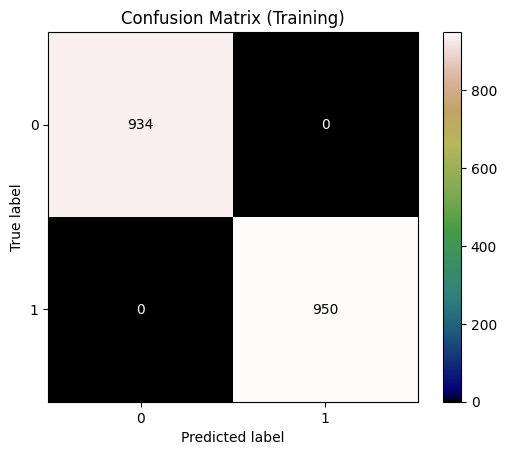

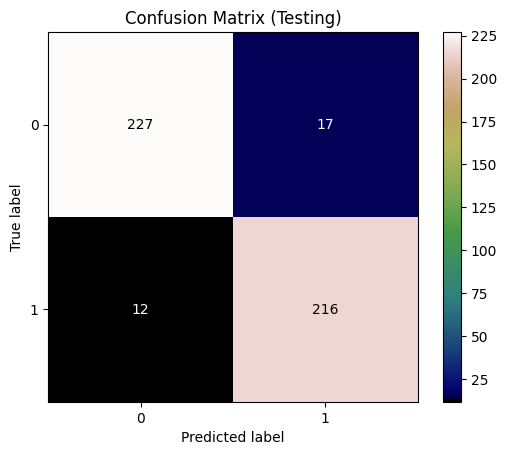

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Assuming y_train and y_test are arrays/lists of discrete class labels
# Ensure that rf_model is a trained classifier
# x_train and x_test should be your feature data

# Plot the confusion matrix for training data including numbers in the plot
cm_train = confusion_matrix(y_train, rf_model.predict(X_train))
ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=rf_model.classes_).plot(cmap='gist_earth', values_format='d')
plt.title("Confusion Matrix (Training)")

# Plot the confusion matrix for testing data, include numbers in the plot
cm_test = confusion_matrix(y_test, rf_model.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=rf_model.classes_).plot(cmap='gist_earth', values_format='d')
plt.title("Confusion Matrix (Testing)")

plt.show()

In [19]:
# average Training accuracy
training_accuracy = accuracy_score(y_train, rf_model.predict(X_train))
print("Average Training accuracy ", training_accuracy)

# average Testing Accuracy
testing_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
print("Average Testing Accuracy", testing_accuracy)

Average Training accuracy  1.0
Average Testing Accuracy 0.9385593220338984


## Precission of model

In [20]:
from sklearn.metrics import  precision_score, recall_score, f1_score, precision_recall_curve

precision = precision_score(y_test, rf_model.predict(X_test), average='weighted')
print("Precision:", precision)

Precision: 0.9388003407666274


In [21]:
recall = recall_score(y_test, rf_model.predict(X_test), average='weighted')
print("Recall:", recall)

Recall: 0.9385593220338984


In [22]:
F1 = f1_score(y_test, rf_model.predict(X_test), average='weighted')
print("F1:", F1)

F1: 0.938574498499176


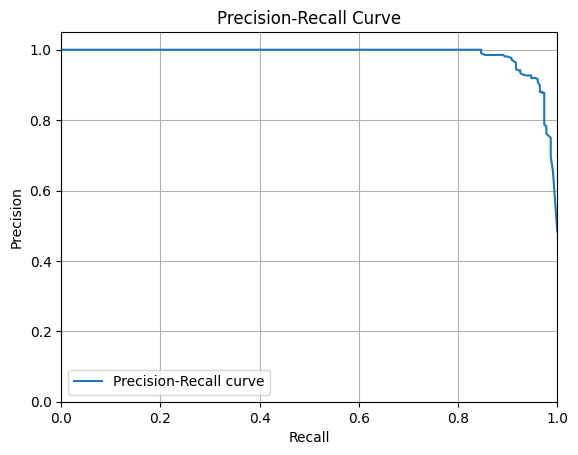

In [23]:
# Precesion recall curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities
y_scores = rf_model.predict_proba(X_test)

# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:, 1])

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid()
plt.show()